## Results Mortality


In [46]:
import numpy as np
import pandas as pd
#from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib inline
import pickle
import palettable
from scipy.sparse import csr_matrix, vstack
from scipy.optimize import curve_fit
import sys 
from netCDF4 import num2date, date2num
import xarray as xr
from netCDF4 import Dataset

import xarray

sys.path.append('../../')

from climada.engine import Impact
from climada.entity import Exposures

from climada.hazard import Hazard
from src.impact_calculation.impact_heat import *
from src.util.plots import *


from scipy.sparse import coo_matrix, vstack

fig_dir = '../../data_analysis/figures/'

In [48]:
directory_exposures = '../../input_data/exposures/'
exposures = {}
for code, category in {'O': 'Over 75', 'U': 'Under 75'}.items():    
    exposures_file = ''.join([directory_exposures, 'exposures_mortality_ch_', code,'2.h5'])
    exposures[category] = Exposures()
    exposures[category].read_hdf5(exposures_file)
    exposures[category].gdf['value'] = exposures[category].gdf['value']*exposures[category].gdf['total_population_canton']

    #exposures[category] = Exposures(exposures[category])
    exposures[category].check()


2022-04-19 16:10:44,171 - climada.entity.exposures.base - WARNING - The use of Exposures.read_hdf5 is deprecated.Use Exposures.from_hdf5 instead.
2022-04-19 16:10:53,358 - climada.entity.exposures.base - WARNING - The use of Exposures.read_hdf5 is deprecated.Use Exposures.from_hdf5 instead.


## Damage cost for each scenario, year and age category

In [49]:
pickle_in = \
open('../../output/mortality_results/impact_CH_values_1000mc_RCP26_RCP45_RCP85_2020_2035_2050.pickle','rb')
impacts_mortality = pickle.load(pickle_in)

pickle_in = \
open('../../output/mortality_results/impact_CH_values_1000mc_RCP26_RCP45_RCP85_2065_2080.pickle','rb')
impacts_mortality_2065 = pickle.load(pickle_in)


In [51]:
impacts_mortality.append_years(impacts_mortality_2065)


In [52]:
data = {}
for scenario in impacts_mortality.median_impact_matrices:
    data[scenario] = {}
    for cat in impacts_mortality.median_impact_matrices[scenario][2020]:
        data[scenario][cat] = vstack([impacts_mortality.median_impact_matrices[scenario][y][cat] 
                for y in impacts_mortality.median_impact_matrices[scenario]]).toarray()
    

In [53]:
impacts_mortality.median_impact_matrices[scenario][2020][cat]

<1x344588 sparse matrix of type '<class 'numpy.float64'>'
	with 335872 stored elements in Compressed Sparse Row format>

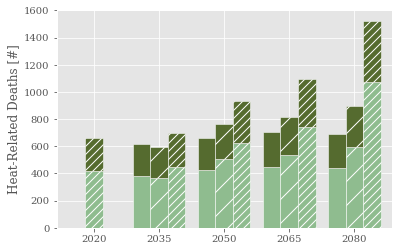

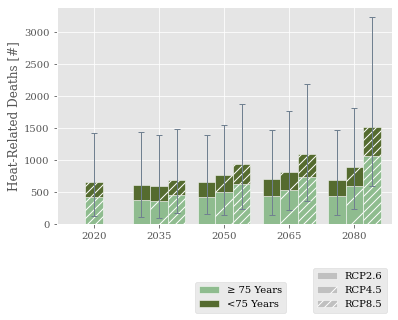

In [54]:
from matplotlib import cycler
IPython_default = plt.rcParams.copy()
colors = cycler('color',
                       ['#EE6666', '#3388BB', '#9988DD',
                        '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
      axisbelow=True, grid=True, prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='blue')
plt.rc('ytick', direction='out', color='gray')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)
plt.rc('font', family='serif')
with plt.style.context('ggplot'):
    plot_impacts_heat(impacts_mortality.agg_impacts_mc, unit='Heat-Related Deaths [#]', impact_type='mortality', color=['darkseagreen', 'darkolivegreen'], labels_cat=['≥ 75 Years','<75 Years'], save=True)



In [88]:
total_death = (impacts_mortality.agg_impacts_mc['RCP26'][2080]['Over 75'].median()+impacts_mortality.agg_impacts_mc['RCP26'][2080]['Under 75'].median())

In [89]:
total_death

701.8704724275644

In [90]:
1524-701

823

In [92]:
823/701

1.174037089871612

In [61]:
impacts_mortality.agg_impacts_mc['RCP85'][2080]['Over 75'].median()

421.66251079903634

In [60]:
impacts_mortality.agg_impacts_mc['RCP85'][2020]['Over 75'].median()/total_death

0.6407653682768645

In [9]:
np.median(impacts_mortality.agg_impacts_mc['RCP85'][2080]['Over 75'])+np.median(impacts_mortality.agg_impacts_mc['RCP85'][2080]['Under 75'])-np.median(impacts_mortality.agg_impacts_mc['RCP26'][2080]['Over 75'])-np.median(impacts_mortality.agg_impacts_mc['RCP26'][2080]['Under 75'])


1816.7956116350538

In [58]:
(np.median(impacts_mortality.agg_impacts_mc['RCP26'][2080]['Over 75'])+np.median(impacts_mortality.agg_impacts_mc['RCP26'][2080]['Under 75']))


701.8704724275644

In [74]:
def median_death(scenario, year, category='all'):
    if category=='all':
        median_death = (np.median(impacts_mortality.agg_impacts_mc[scenario][year]['Over 75'])+np.median(impacts_mortality.agg_impacts_mc[scenario][year]['Under 75']))
    else:    
        median_death = np.median(impacts_mortality.agg_impacts_mc[scenario][year][category])
    return median_death

def percentile_death(scenario, year, percentile, category='all'):
    if category=='all':
        median_death = (np.percentile(impacts_mortality.agg_impacts_mc[scenario][year]['Over 75'], percentile)+np.percentile(impacts_mortality.agg_impacts_mc[scenario][year]['Under 75'], percentile))
    else:    
        median_death = np.percentile(impacts_mortality.agg_impacts_mc[scenario][year][category],percentile)
    return median_death

def max_death(scenario, year, category='all'):
    if category=='all':
        median_death = (np.max(impacts_mortality.agg_impacts_mc[scenario][year]['Over 75'])+np.max(impacts_mortality.agg_impacts_mc[scenario][year]['Under 75']))
    else:    
        median_death = np.max(impacts_mortality.agg_impacts_mc[scenario][year][category])
    return median_death

In [80]:
print(percentile_death('RCP85', 2050, 60, category='all'))
print(percentile_death('RCP85', 2050, 60, category='all'))
print(median_death('RCP85', 2050))

print(median_death('RCP85', 2050) - percentile_death('RCP85', 2050, 90, category='all'))
print(median_death('RCP85', 2050) - percentile_death('RCP85', 2050, 95, category='all'))


1063.2280968861617
1063.2280968861617
934.3947249998921
-686.5297542482183
-949.5044602320418


In [13]:
percentile_death('RCP85', 2050, 60, category='all')

1063.2280968861617

## Spatial Impact

/Users/szelie/miniconda3/envs/climada_env/lib/python3.8/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)


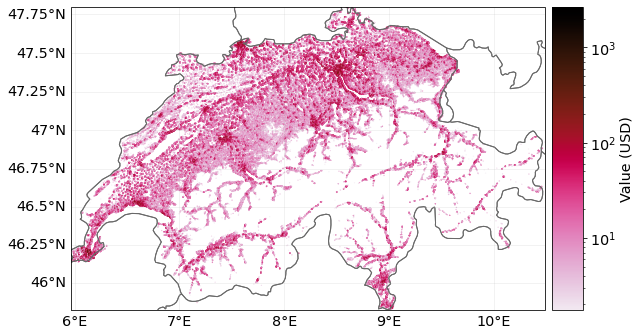

In [24]:
import matplotlib
from climada.util.plot import make_map
import cartopy.crs as ccrs
import matplotlib


exposures['Under 75'].check()
exposures['Under 75'].to_crs(epsg=3785, inplace=True)

exposures['Under 75'].plot_hexbin(pop_name=False, buffer=0.1, norm=matplotlib.colors.LogNorm())
plt.savefig('../figures/map_exposures_ch_u75.pdf',bbox_inches='tight')   


/Users/szelie/miniconda3/envs/climada_env/lib/python3.8/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)


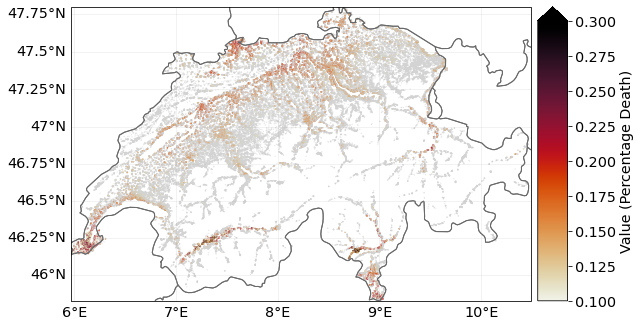

In [25]:
category = 'Over 75'
categories_code = {'Over 75':'O', 'Under 75':'U'}
cm = palettable.cartocolors.sequential.Emrld_7.mpl_colormap

impact = impacts_mortality.matrix_as_impact(impacts_mortality.median_impact_matrices['RCP85'][2050][category], exposures[category], percentage=True, unit='Percentage Death')

impact.plot_hexbin_impact_exposure(pop_name=False, vmin=0.1, vmax=0.3, extend='max')

plt.savefig(''.join([fig_dir,'spatial_impact_2050_o75.pdf']),bbox_inches='tight')

## Relative change map

/Users/szelie/miniconda3/envs/climada_env/lib/python3.8/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)


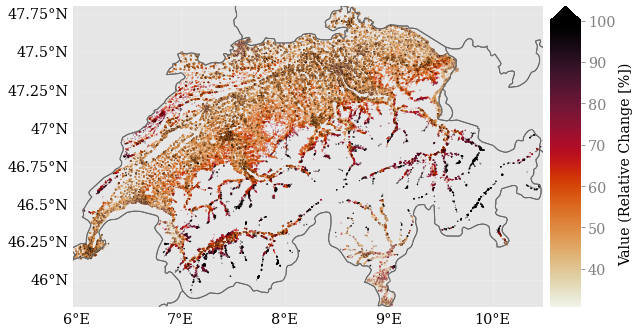

In [16]:
rel_mat = ImpactsHeatMortality.compute_relative_change(impacts_mortality.median_impact_matrices['RCP85'][2050][category], impacts_mortality.median_impact_matrices['RCP85'][2020][category])
impacts_rel = ImpactsHeatMortality.matrix_as_impact(rel_mat, exposures[category], unit='Relative Change [%]')
impacts_rel.plot_hexbin_impact_exposure(pop_name=False, buffer=0.1, vmax=100, extend='max')

plt.savefig(''.join([fig_dir,'relative_changes_2020_2050_o75.pdf']),bbox_inches='tight')

/Users/szelie/miniconda3/envs/climada_env/lib/python3.8/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)


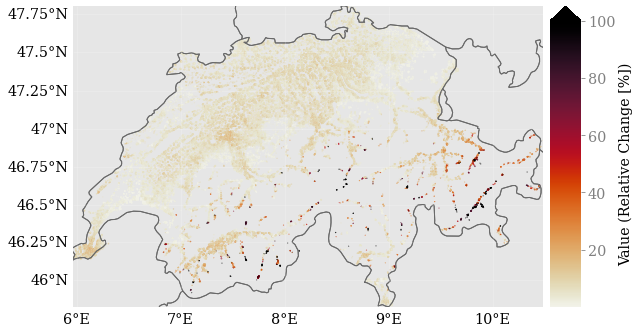

In [17]:
rel_mat = ImpactsHeatMortality.compute_relative_change(impacts_mortality.median_impact_matrices['RCP26'][2050][category], impacts_mortality.median_impact_matrices['RCP85'][2020][category])
impacts_rel = ImpactsHeatMortality.matrix_as_impact(rel_mat, exposures[category], unit='Relative Change [%]')
impacts_rel.plot_hexbin_impact_exposure(pop_name=False,  buffer=0.1, vmax=100, extend='max')

plt.savefig(''.join([fig_dir,'relative_changes_2020_2050_o75_rcp26.pdf']),bbox_inches='tight')

## Make Table with Cantonal Values

In [93]:
categories_short = {'Over 75': '≥75', 'Under 75': '<75'}
#cantonal_impacts_df = impacts_mortality.median_impact_matrices['RCP26'][2020]=impacts_mortality.median_impact_matrices['RCP26'][2080]
#cantonal_impacts_df = impacts_mortality.median_impact_matrices['RCP45'][2020]=impacts_mortality.median_impact_matrices['RCP45'][2080]

cantonal_impacts_df = impacts_mortality.cantonal_impacts_df(exposures, scenarios=['RCP26', 'RCP85'], years=[2020,2050,2080], categories_short=categories_short)


In [94]:
cantonal_impacts_df_rcp45 = impacts_mortality.cantonal_impacts_df(exposures, scenarios=['RCP45'], years=[2020,2050,2080], categories_short=categories_short)


In [95]:
cantonal_impacts_df_rcp45

RCP4.5                                      \
                              2020                    2050               
                               ≥75         <75         ≥75         <75   
canton                                                                   
Aargau                   32.848394   20.733935   47.205447   24.925509   
Appenzell Ausserrhoden    1.117918    1.025483    1.841517    1.307781   
Appenzell Innerrhoden     0.337156    0.302491    0.558949    0.389957   
Basel-Landschaft         17.220540    8.350728   24.126543    9.939831   
Basel-Stadt              10.421129    4.704662   14.428072    5.610409   
Bern                     46.015560   27.524993   67.975632   33.436805   
Fribourg                 10.911102    9.209183   15.962987   11.156970   
Genève                   25.929394   13.862645   36.860713   17.249067   
Glarus                    1.223300    0.839920    1.955469    1.082503   
Graubünden                6.432473    4.056122   10.623379    5.526088   
Jura                      3.774266    2.237225    5.470567    2.741154   
Luzern                   15.203667   10.560876   22.816234   12.845915   
Neuchâtel                 5.968631    3.759566    8.665944    4.572332   
Nidwalden                 1.670078    1.041531    2.601886    1.298601   
Obwalden                  1.164517    0.906668    1.880405    1.161881   
Schaffhausen              4.473737    2.396691    6.352892    2.863075   
Schwyz                    4.438764    3.425142    6.887106    4.248471   
Solothurn                15.142932    8.762473   21.497934   10.395386   
St. Gallen               17.113518   12.445387   25.898853   15.285115   
Thurgau                  10.828112    7.931948   15.849854    9.592091   
Ticino                   26.391934   12.867761   35.464387   14.659328   
Uri                       1.054373    0.734699    1.714162    0.958897   
Valais                   15.653846    9.990500   24.679726   12.971746   
Vaud                     29.478330   21.030248   42.173961   25.085841   
Zug                       3.681257    2.729420    5.552510    3.341959   
Zürich                   58.942693   36.722033   85.727846   44.357777   
Total                   367.437620  228.152332  534.772978  277.004490   

                                                
                              2080              
                               ≥75         <75  
canton                                          
Aargau                   48.808849   26.297628  
Appenzell Ausserrhoden    1.954399    1.392078  
Appenzell Innerrhoden     0.595860    0.416724  
Basel-Landschaft         25.096981   10.521403  
Basel-Stadt              14.745563    5.868840  
Bern                     71.491293   35.845647  
Fribourg                 16.808930   11.975538  
Genève                   38.015208   18.243665  
Glarus                    2.111568    1.166540  
Graubünden               11.764165    6.122265  
Jura                      5.841987    2.931261  
Luzern                   23.545556   13.635930  
Neuchâtel                 9.293955    4.913772  
Nidwalden                 2.637175    1.395401  
Obwalden                  1.965572    1.260833  
Schaffhausen              6.577483    3.008647  
Schwyz                    7.162601    4.539205  
Solothurn                22.437098   11.062355  
St. Gallen               26.908455   16.165672  
Thurgau                  16.339886    9.999957  
Ticino                   39.096635   15.513014  
Uri                       1.881163    1.053445  
Valais                   27.340058   14.266266  
Vaud                     44.913740   26.980791  
Zug                       5.731878    3.514557  
Zürich                   88.262485   46.417957  
Total                   561.328542  294.509391

In [96]:
cantonal_impacts_df

RCP2.6                                      \
                              2020                    2050               
                               ≥75         <75         ≥75         <75   
canton                                                                   
Aargau                   34.460490   21.067508   38.812799   23.209545   
Appenzell Ausserrhoden    1.210454    1.039325    1.350759    1.189502   
Appenzell Innerrhoden     0.368110    0.307437    0.412370    0.353407   
Basel-Landschaft         18.090413    8.457719   20.200783    9.394709   
Basel-Stadt              10.792117    4.725105   12.012638    5.278779   
Bern                     48.846370   28.103681   55.656509   31.347037   
Fribourg                 11.405882    9.387892   13.101856   10.499059   
Genève                   25.877622   14.077774   30.326182   15.884220   
Glarus                    1.306503    0.862133    1.520474    0.990483   
Graubünden                6.763284    4.169572    8.305948    4.938890   
Jura                      4.080568    2.291234    4.548789    2.598269   
Luzern                   16.102819   10.752640   18.468314   11.926767   
Neuchâtel                 6.256068    3.790857    7.083975    4.282054   
Nidwalden                 1.746787    1.069943    2.051295    1.201325   
Obwalden                  1.236394    0.940003    1.456812    1.065194   
Schaffhausen              4.686788    2.442251    5.278725    2.703420   
Schwyz                    4.736002    3.506292    5.416144    3.940008   
Solothurn                15.913369    8.889986   17.916458    9.775081   
St. Gallen               17.975377   12.686109   20.534365   14.182347   
Thurgau                  11.359609    7.992280   12.783369    8.905387   
Ticino                   27.441774   12.820080   29.922807   13.820612   
Uri                       1.120833    0.760214    1.349903    0.876024   
Valais                   16.200371   10.105423   19.566723   11.595694   
Vaud                     30.328473   21.300863   34.308176   23.707311   
Zug                       3.902414    2.767178    4.424447    3.082687   
Zürich                   61.908281   37.226342   70.300188   41.256762   
Total                   384.117168  231.539838  437.110808  258.004572   

                                                    RCP8.5              \
                              2080                    2020               
                               ≥75         <75         ≥75         <75   
canton                                                                   
Aargau                   40.458133   22.467004   36.964225   21.253388   
Appenzell Ausserrhoden    1.539901    1.170975    1.375609    1.085549   
Appenzell Innerrhoden     0.468266    0.346373    0.412830    0.320216   
Basel-Landschaft         21.066344    9.039211   19.612443    8.547313   
Basel-Stadt              12.487815    5.037885   11.685328    4.838446   
Bern                     57.257461   30.166734   52.681919   28.442749   
Fribourg                 13.487323   10.120163   12.480294    9.494014   
Genève                   29.122375   14.975479   28.017082   14.439952   
Glarus                    1.592896    0.939137    1.454097    0.891925   
Graubünden                8.343390    4.659173    7.515482    4.338457   
Jura                      4.727932    2.476976    4.361630    2.313708   
Luzern                   19.019298   11.475931   17.469569   10.863565   
Neuchâtel                 7.436611    4.131790    6.864443    3.891630   
Nidwalden                 2.084834    1.146370    1.917772    1.087041   
Obwalden                  1.493800    1.013351    1.363588    0.960197   
Schaffhausen              5.499450    2.588320    5.101257    2.460719   
Schwyz                    5.711665    3.788724    5.268806    3.569657   
Solothurn                18.610719    9.464065   17.083860    8.982281   
St. Gallen               21.730134   13.785539   20.059476   12.943725   
Thurgau                  13.461

In [97]:
cantonal_impacts_df_total = cantonal_impacts_df.groupby(level=[0,1], axis=1).sum().astype(int)

In [98]:
cantonal_impacts_df_total

RCP2.6           RCP8.5           
                         2020 2050 2080   2020 2050  2080
canton                                                   
Aargau                     55   62   62     58   82   133
Appenzell Ausserrhoden      2    2    2      2    3     6
Appenzell Innerrhoden       0    0    0      0    1     1
Basel-Landschaft           26   29   30     28   39    64
Basel-Stadt                15   17   17     16   22    36
Bern                       76   87   87     81  116   193
Fribourg                   20   23   23     21   31    51
Genève                     39   46   44     42   61   100
Glarus                      2    2    2      2    3     6
Graubünden                 10   13   13     11   18    33
Jura                        6    7    7      6    9    16
Luzern                     26   30   30     28   40    67
Neuchâtel                  10   11   11     10   15    25
Nidwalden                   2    3    3      3    4     7
Obwalden                    2    2    2      2    3     5
Schaffhausen                7    7    8      7   10    17
Schwyz                      8    9    9      8   12    21
Solothurn                  24   27   28     26   36    59
St. Gallen                 30   34   35     33   46    76
Thurgau                    19   21   22     20   28    46
Ticino                     40   43   43     42   56    91
Uri                         1    2    2      2    3     5
Valais                     26   31   30     28   43    73
Vaud                       51   58   58     55   77   125
Zug                         6    7    7      7   10    16
Zürich                     99  111  112    105  147   242
Total                     615  695  698    653  925  1526

In [99]:
cantonal_impacts_df_total.insert(0, 'Baseline (2020)', cantonal_impacts_df_total['RCP8.5'][2020])

In [100]:
cantonal_impacts_df['RCP8.5'][2020]['≥75']/(cantonal_impacts_df['RCP8.5'][2020]['≥75']+cantonal_impacts_df['RCP8.5'][2020]['<75'])
                                                                                                                           

canton
Aargau                    0.634932
Appenzell Ausserrhoden    0.558927
Appenzell Innerrhoden     0.563171
Basel-Landschaft          0.696471
Basel-Stadt               0.707183
Bern                      0.649395
Fribourg                  0.567949
Genève                    0.659893
Glarus                    0.619814
Graubünden                0.634007
Jura                      0.653395
Luzern                    0.616577
Neuchâtel                 0.638192
Nidwalden                 0.638233
Obwalden                  0.586796
Schaffhausen              0.674593
Schwyz                    0.596122
Solothurn                 0.655404
St. Gallen                0.607804
Thurgau                   0.605542
Ticino                    0.695154
Uri                       0.612112
Valais                    0.632643
Vaud                      0.610262
Zug                       0.600658
Zürich                    0.640358
Total                     0.640020
dtype: float64

In [101]:
cantonal_impacts_df

RCP2.6                                      \
                              2020                    2050               
                               ≥75         <75         ≥75         <75   
canton                                                                   
Aargau                   34.460490   21.067508   38.812799   23.209545   
Appenzell Ausserrhoden    1.210454    1.039325    1.350759    1.189502   
Appenzell Innerrhoden     0.368110    0.307437    0.412370    0.353407   
Basel-Landschaft         18.090413    8.457719   20.200783    9.394709   
Basel-Stadt              10.792117    4.725105   12.012638    5.278779   
Bern                     48.846370   28.103681   55.656509   31.347037   
Fribourg                 11.405882    9.387892   13.101856   10.499059   
Genève                   25.877622   14.077774   30.326182   15.884220   
Glarus                    1.306503    0.862133    1.520474    0.990483   
Graubünden                6.763284    4.169572    8.305948    4.938890   
Jura                      4.080568    2.291234    4.548789    2.598269   
Luzern                   16.102819   10.752640   18.468314   11.926767   
Neuchâtel                 6.256068    3.790857    7.083975    4.282054   
Nidwalden                 1.746787    1.069943    2.051295    1.201325   
Obwalden                  1.236394    0.940003    1.456812    1.065194   
Schaffhausen              4.686788    2.442251    5.278725    2.703420   
Schwyz                    4.736002    3.506292    5.416144    3.940008   
Solothurn                15.913369    8.889986   17.916458    9.775081   
St. Gallen               17.975377   12.686109   20.534365   14.182347   
Thurgau                  11.359609    7.992280   12.783369    8.905387   
Ticino                   27.441774   12.820080   29.922807   13.820612   
Uri                       1.120833    0.760214    1.349903    0.876024   
Valais                   16.200371   10.105423   19.566723   11.595694   
Vaud                     30.328473   21.300863   34.308176   23.707311   
Zug                       3.902414    2.767178    4.424447    3.082687   
Zürich                   61.908281   37.226342   70.300188   41.256762   
Total                   384.117168  231.539838  437.110808  258.004572   

                                                    RCP8.5              \
                              2080                    2020               
                               ≥75         <75         ≥75         <75   
canton                                                                   
Aargau                   40.458133   22.467004   36.964225   21.253388   
Appenzell Ausserrhoden    1.539901    1.170975    1.375609    1.085549   
Appenzell Innerrhoden     0.468266    0.346373    0.412830    0.320216   
Basel-Landschaft         21.066344    9.039211   19.612443    8.547313   
Basel-Stadt              12.487815    5.037885   11.685328    4.838446   
Bern                     57.257461   30.166734   52.681919   28.442749   
Fribourg                 13.487323   10.120163   12.480294    9.494014   
Genève                   29.122375   14.975479   28.017082   14.439952   
Glarus                    1.592896    0.939137    1.454097    0.891925   
Graubünden                8.343390    4.659173    7.515482    4.338457   
Jura                      4.727932    2.476976    4.361630    2.313708   
Luzern                   19.019298   11.475931   17.469569   10.863565   
Neuchâtel                 7.436611    4.131790    6.864443    3.891630   
Nidwalden                 2.084834    1.146370    1.917772    1.087041   
Obwalden                  1.493800    1.013351    1.363588    0.960197   
Schaffhausen              5.499450    2.588320    5.101257    2.460719   
Schwyz                    5.711665    3.788724    5.268806    3.569657   
Solothurn                18.610719    9.464065   17.083860    8.982281   
St. Gallen               21.730134   13.785539   20.059476   12.943725   
Thurgau                  13.461

In [103]:
with pd.option_context("max_colwidth", 1000):
    print(cantonal_impacts_df_total.to_latex(multicolumn=True))


\begin{tabular}{lrrrrrrr}
\toprule
{} & Baseline (2020) & \multicolumn{3}{l}{RCP2.6} & \multicolumn{3}{l}{RCP8.5} \\
{} &   2020 & 2050 & 2080 &   2020 & 2050 &  2080 \\
canton                 &                 &        &      &      &        &      &       \\
\midrule
Aargau                 &              58 &     55 &   62 &   62 &     58 &   82 &   133 \\
Appenzell Ausserrhoden &               2 &      2 &    2 &    2 &      2 &    3 &     6 \\
Appenzell Innerrhoden  &               0 &      0 &    0 &    0 &      0 &    1 &     1 \\
Basel-Landschaft       &              28 &     26 &   29 &   30 &     28 &   39 &    64 \\
Basel-Stadt            &              16 &     15 &   17 &   17 &     16 &   22 &    36 \\
Bern                   &              81 &     76 &   87 &   87 &     81 &  116 &   193 \\
Fribourg               &              21 &     20 &   23 &   23 &     21 &   31 &    51 \\
Genève                 &              42 &     39 &   46 &   44 &     42 &   61 &   100 \\
Gl

/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_43544/2243384312.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(cantonal_impacts_df_total.to_latex(multicolumn=True))


In [104]:
cantonal_impacts_df_total = cantonal_impacts_df_total.drop(columns=2020,level=1)

In [105]:
(cantonal_impacts_df_total['RCP8.5'][2080]-cantonal_impacts_df_total['RCP2.6'][2080])

canton
Aargau                     71
Appenzell Ausserrhoden      4
Appenzell Innerrhoden       1
Basel-Landschaft           34
Basel-Stadt                19
Bern                      106
Fribourg                   28
Genève                     56
Glarus                      4
Graubünden                 20
Jura                        9
Luzern                     37
Neuchâtel                  14
Nidwalden                   4
Obwalden                    3
Schaffhausen                9
Schwyz                     12
Solothurn                  31
St. Gallen                 41
Thurgau                    24
Ticino                     48
Uri                         3
Valais                     43
Vaud                       67
Zug                         9
Zürich                    130
Total                     828
Name: 2080, dtype: int64

In [106]:
cantonal_impacts_df_total['RCP2.6'][2080]

canton
Aargau                     62
Appenzell Ausserrhoden      2
Appenzell Innerrhoden       0
Basel-Landschaft           30
Basel-Stadt                17
Bern                       87
Fribourg                   23
Genève                     44
Glarus                      2
Graubünden                 13
Jura                        7
Luzern                     30
Neuchâtel                  11
Nidwalden                   3
Obwalden                    2
Schaffhausen                8
Schwyz                      9
Solothurn                  28
St. Gallen                 35
Thurgau                    22
Ticino                     43
Uri                         2
Valais                     30
Vaud                       58
Zug                         7
Zürich                    112
Total                     698
Name: 2080, dtype: int64

In [107]:
(cantonal_impacts_df_total['RCP8.5'][2080]-cantonal_impacts_df_total['RCP2.6'][2080])/(cantonal_impacts_df_total['RCP2.6'][2080])




canton
Aargau                    1.145161
Appenzell Ausserrhoden    2.000000
Appenzell Innerrhoden          inf
Basel-Landschaft          1.133333
Basel-Stadt               1.117647
Bern                      1.218391
Fribourg                  1.217391
Genève                    1.272727
Glarus                    2.000000
Graubünden                1.538462
Jura                      1.285714
Luzern                    1.233333
Neuchâtel                 1.272727
Nidwalden                 1.333333
Obwalden                  1.500000
Schaffhausen              1.125000
Schwyz                    1.333333
Solothurn                 1.107143
St. Gallen                1.171429
Thurgau                   1.090909
Ticino                    1.116279
Uri                       1.500000
Valais                    1.433333
Vaud                      1.155172
Zug                       1.285714
Zürich                    1.160714
Total                     1.186246
Name: 2080, dtype: float64

In [108]:
cantonal_impacts_df_total

Baseline (2020) RCP2.6      RCP8.5      
                                         2050 2080   2050  2080
canton                                                         
Aargau                              58     62   62     82   133
Appenzell Ausserrhoden               2      2    2      3     6
Appenzell Innerrhoden                0      0    0      1     1
Basel-Landschaft                    28     29   30     39    64
Basel-Stadt                         16     17   17     22    36
Bern                                81     87   87    116   193
Fribourg                            21     23   23     31    51
Genève                              42     46   44     61   100
Glarus                               2      2    2      3     6
Graubünden                          11     13   13     18    33
Jura                                 6      7    7      9    16
Luzern                              28     30   30     40    67
Neuchâtel                           10     11   11     15    25
Nidwalden                            3      3    3      4     7
Obwalden                             2      2    2      3     5
Schaffhausen                         7      7    8     10    17
Schwyz                               8      9    9     12    21
Solothurn                           26     27   28     36    59
St. Gallen                          33     34   35     46    76
Thurgau                             20     21   22     28    46
Ticino                              42     43   43     56    91
Uri                                  2      2    2      3     5
Valais                              28     31   30     43    73
Vaud                                55     58   58     77   125
Zug                                  7      7    7     10    16
Zürich                             105    111  112    147   242
Total                              653    695  698    925  1526

In [110]:
with pd.option_context("max_colwidth", 1000):
    print(cantonal_impacts_df_total.to_latex(multicolumn=True))


\begin{tabular}{lrrrrr}
\toprule
{} & Baseline (2020) & \multicolumn{2}{l}{RCP2.6} & \multicolumn{2}{l}{RCP8.5} \\
{} &   2050 & 2080 &   2050 &  2080 \\
canton                 &                 &        &      &        &       \\
\midrule
Aargau                 &              58 &     62 &   62 &     82 &   133 \\
Appenzell Ausserrhoden &               2 &      2 &    2 &      3 &     6 \\
Appenzell Innerrhoden  &               0 &      0 &    0 &      1 &     1 \\
Basel-Landschaft       &              28 &     29 &   30 &     39 &    64 \\
Basel-Stadt            &              16 &     17 &   17 &     22 &    36 \\
Bern                   &              81 &     87 &   87 &    116 &   193 \\
Fribourg               &              21 &     23 &   23 &     31 &    51 \\
Genève                 &              42 &     46 &   44 &     61 &   100 \\
Glarus                 &               2 &      2 &    2 &      3 &     6 \\
Graubünden             &              11 &     13 &   13 &     18 &

/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_43544/2243384312.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(cantonal_impacts_df_total.to_latex(multicolumn=True))
